In [48]:
import fitsio
import numpy as np
import time
from mpmath import *
from concurrent.futures import ProcessPoolExecutor as Executor

In [60]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import ImageGrid

cmap=plt.get_cmap('RdBu')

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=0)

In [3]:
file_name = '~/google-drive/PhD/NPCF/codes_npcf/treeCorr/convergence/data/Aardvark_cpy.fit'
data = fitsio.read(file_name)

In [7]:
print(data.dtype)

[('INDEX', '>i4'), ('RA', '>f4'), ('DEC', '>f4'), ('Z', '>f4'), ('EPSILON', '>f4', (2,)), ('GAMMA1', '>f4'), ('GAMMA2', '>f4'), ('KAPPA', '>f4'), ('MU', '>f4')]


In [9]:
def get_r(A=[],B=[],weight=False):                                                                         
    """                                                                                                   
    weight false means len(r)=len(A)                                                                      
    """                                                                                                   
    EPS=10**(-8)
    if (type(A)==int) and (type(B)==int)\
        or (type(A)==float)and(type(B)==float):
        tmpj=abs(A-B)
    else:
        tmpA,tmpB=len(A),len(B)                                                                               
        if tmpA!=tmpB:sys.exit("points have different length")                                                        
        tmpj=0.                                                                                               
        if not weight:                                                                                             
            dim= tmpA                                                                                         
        else:                                                                                                 
            dim= tmpA -1                                                                                      
        for ii in range(dim):                                                                                 
            tmpj+= np.square(A[ii]-B[ii])
        tmpj=np.sqrt(tmpj)
    return tmpj
def get_mu(A,B,C):                                                                                       
    """                                                                                                   
    get polar angle between rays A and B, length of rays are recieved.                                           
    A is used as axis for polar angle                                                                          
    angle is taken 0,pi                                                                                   
    """                                                                                                   
    EPS=10**(-8)
    if A<EPS or B<EPS:
        return np.nan
    mu=(A*A+B*B-C*C)/(A*B)
    if abs(mu)-1>EPS:
        return np.nan
    #elif abs(mu)<EPS:
    #    return -1
    return mu
def get_tht(mu):
    EPS=1*10**(-8)
    return np.arccos(mu)
def addPhase(tht,i,k,l,n):
    if i<k:
        if l>=n: return tht
        else: return 2*np.pi-tht
    elif i>k:
        if l>=n: return tht
        else: return np.pi+tht
    else:
        if l>n: return np.pi/2
        elif l<n: return 3*np.pi/2
        else: np.nan
    return None
def get_lindbin(d,nbin,dmax):
    EPS=1.*10**(-8)
    if d<EPS:
        return 0
    return ceil((d/dmax)*nbin)-1
def get_linmubin(mu,nbin,mumax):
    EPS=1.*10**(-8)
    return ceil(((mu+1)/(mumax+1))*nbin)-1 #remove +1 if mu goes from 0 to 1
def get_linthtbin(tht,nbin,thtmax):
    return ceil(((tht)/(thtmax))*nbin)-1
def get_params(Nchunks,data):
    Nsize=len(data)/Nchunks
    params=[]
    for ii in range(Nchunks):
        params.append([int(ii*Nsize),int((ii+1)*Nsize)])
    return params

In [13]:
dataConv=[]
for ii,jj,kk in zip(data["RA"],data["DEC"],data["KAPPA"]):
    dataConv.append([ii,jj,kk])

In [14]:
dataConv[0]

[56.4195, 84.2215, -5.6952184e-05]

In [19]:
min(data["DEC"])

78.4209

In [62]:
def f(nmin,nmax,nskip,data,rmin,rmax,hist):
    """
    Recieves an array of data with celestial coordinates and calculates the <KKK> by brute force
    INPUT:
    nmin int for start point in data. It serves for parallel running
    nmax int for end point in data. It serves for parallel running
    nskip int amount to skip in data 
    data array (m,3) containing RA,DEC,KAPPA
    rmin/rmax float to use for min/max scale in correlation
    hist array it sould be the size of the dessired hist, so it carries info about the bin size for r1,r2,tht
    OUTPUT:
    hist array with the correlation functions for r1,r2,tht
    """
    hist=hist.copy()
    ldata=len(data)
    nrbin=len(hist)
    nmubin=len(hist[0,0,:])
    for ii in range(nmin,nmax)[::nskip]:
        #if ii%10==0:print(ii)
        for jj in range(ldata)[::nskip]:
            for kk in range(ldata)[::nskip]:
                #if (mm==kk) and (nn==ll):continue
                if ii==jj:continue
                r1=get_r([data[ii][0],data[ii][1]],[data[jj][0],data[jj][1]])
                if r1>rmax or r1 < rmin: continue
                r2=get_r([data[ii][0],data[ii][1]],[data[kk][0],data[kk][1]])
                if r2>rmax or r2 < rmin: continue
                mu=get_mu(r1,r2,get_r([data[jj][0],data[jj][1]],\
                                      [data[kk][0],data[kk][1]]))                      
                if np.isnan(mu): continue                                
                tht=get_tht(mu)
                #tht=addPhase(get_tht(mu),ii,kk,ll,nn)# using r2 as axis to get tht
                #if np.isnan(tht): continue
                #addToHist(r1,r2,tht,w) 
                binr1=int(get_lindbin(r1,nrbin,rmax))
                binr2=int(get_lindbin(r2,nrbin,rmax))
                #binmu=int(get_linmubin(mu,nmubin,1))
                bintht=int(get_linthtbin(tht,nmubin,np.pi))
                #print("%d %d\t\t%d %d\t\t%d %d\t\t%5.2f %5.2f\t\t%2.5f"%(ii,jj,kk,ll,mm,nn,r1,r2,mu))
                #print("%4.1f %d\t\t%4.1f %d\t\t%4.1f %d"%(r1,binr1,r2,binr2,mu,binmu))
                #if binr1>nrbin-1 or binr2>nrbin-1 or binmu > nmubin-1:
                #    print("%d %d\t%d %d\t%d %d\t%5.2f %5.2f\t%2.5f\t%d %d %d"%(ii,jj,kk,ll,mm,nn,r1,r2,mu,binr1,binr2,binmu))
                try:
                    hist[binr1,binr2,bintht]+=\
                            data[ii][2]*data[jj][2]*data[kk][2]
                    #w[ii,jj]*largew[kk,ll]*largew[mm,nn]
                except IndexError:
                    print("%d %d\t\t%d %d\t\t%d %d\t\t%d\t\t%d\t\t%d"%(ii,jj,kk,ll,mm,nn,binr1,binr2,binmu))
                    #print(ii,jj,kk,ll,mm,nn,binr1,binr2,binmu,sep="\t")
    return hist

In [21]:
nrbin=30 #bins r
nmubin=30 #bins mu
nthtbin=30
nskip=2 #step in pts
rmin= 1.
rmax= 15.

In [70]:
hist_rrtht=np.zeros((nrbin,nrbin,nthtbin))
t1=time.perf_counter()
jobs=[]
Nchunks=10 #threads per job
params=get_params(Nchunks,dataConv[:2000])
results=[]
for ii in params:
    #print(type(ii),ii)
    ii.append(nskip)
    ii.append(hist_rrtht)
    jobs.append(Executor(max_workers=2).submit(f,ii[0],ii[1],nskip,dataConv[:2000],\
               rmin,rmax,hist_rrtht))
for ii in jobs:
    results.append(ii.result())
t2=time.perf_counter()
print("time:%7.2f"%(t2-t1))
for ii in results:
    hist_rrtht+=np.array(ii)

time:2417.05


In [71]:
np.save("/home/joar/temporal/NPCF_data/BruteForce/bruteForceSzapudiConvergence_rrtht",hist_rrtht)

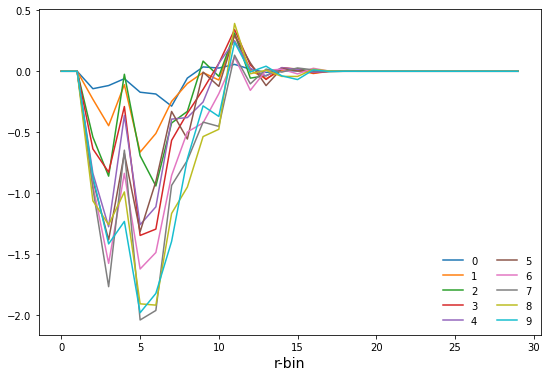

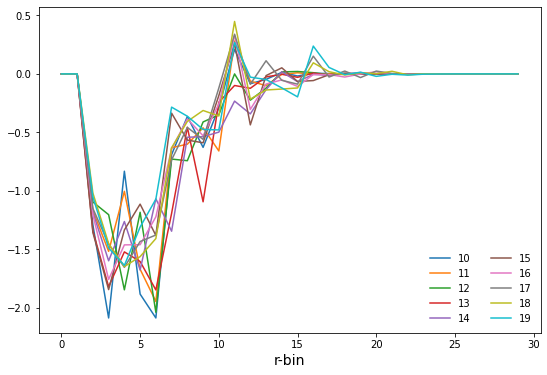

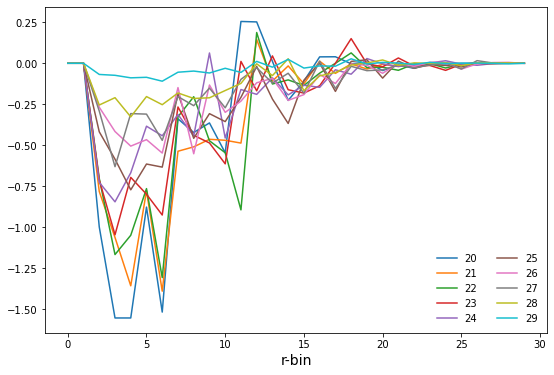

In [72]:
plt.figure(figsize=(9,6))
for ii in range(10):
    plt.plot(np.diagonal(hist_rrtht[:,:,ii]/np.max(hist_rrtht)),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)
plt.show()
plt.figure(figsize=(9,6))
for ii in range(10,20):
    plt.plot(np.diagonal(hist_rrtht[:,:,ii]/np.max(hist_rrtht)),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)
plt.show()
plt.figure(figsize=(9,6))
for ii in range(20,30):
    plt.plot(np.diagonal(hist_rrtht[:,:,ii]/np.max(hist_rrtht)),label="%d"%(ii))
plt.legend(frameon=False,ncol=2)
plt.xlabel("r-bin",fontsize=14)
plt.show()

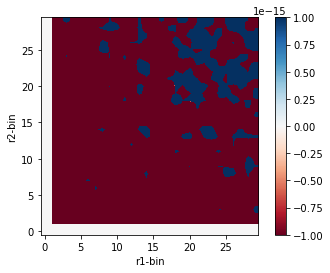

In [75]:
scaleplot=10**(-15)
plt.imshow(hist_rrtht[:,:,29],origin='lower',cmap=cmap,\
    interpolation='bilinear', norm=norm, vmin=-scaleplot,\
    vmax=scaleplot)
plt.colorbar()
plt.ylabel('r2-bin')
plt.xlabel('r1-bin')
plt.show()